# Mood-Based Restaurant Classifier - Model Training
Fine-tuning DistilBERT for multi-label mood classification

## Setup and Installation

In [1]:
# Install required packages
!pip install transformers datasets torch scikit-learn pandas numpy matplotlib seaborn tqdm -q

In [2]:
# Clone repository (run only in Colab)
import os
if 'COLAB_GPU' in os.environ:
    !git clone https://github.com/Rohanjain2312/mood-based-restaurant-recommender.git
    %cd mood-based-restaurant-recommender

Cloning into 'mood-based-restaurant-recommender'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 51 (delta 0), reused 51 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (51/51), 199.37 KiB | 2.73 MiB/s, done.
/content/mood-based-restaurant-recommender


In [4]:
import json
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if device.type == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB


## Load and Explore Data

In [6]:
# Load labeled reviews
with open('data/labeled/labeled_reviews.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

print(f'Total reviews: {len(data)}')
print(f'Sample review:\n{data[0]}')

Total reviews: 227
Sample review:
{'restaurant_name': "Connolly's", 'city': 'New York City', 'place_id': 'ChIJAS6GeVVYwokRPfg8xt4nH-I', 'review_text': 'Our favourite bar during our entire stay. We visited every day after our first visit was so great, and it became our local! The food was delicious and the service impeccable. Special shout out to Darren the legend. He made us feel so welcome every visit, especially with how busy this bar is and he remembered us and our drinks order and even the football team my parter supported so the bar felt very homely. Would 10/10 recommend. Get yourselves to Connolly’s guys. Will be back next year', 'review_rating': 5, 'review_author': 'Leah Lewis', 'moods': ['celebration'], 'mood_confidence': 0.7}


In [31]:
# Define mood categories
MOODS = ['date', 'quick_bite', 'budget', 'celebration']
NUM_LABELS = len(MOODS)

print(f'Mood categories: {MOODS}')
print(f'Number of labels: {NUM_LABELS}')

Mood categories: ['date', 'quick_bite', 'budget', 'celebration']
Number of labels: 4


In [32]:
# Convert to DataFrame for easier manipulation
df = pd.DataFrame(data)

# Create binary labels for each mood
for mood in MOODS:
    df[mood] = df['moods'].apply(lambda x: 1 if mood in x else 0)

print(f'\nDataFrame shape: {df.shape}')
print(f'\nFirst few rows:')
print(df[['review_text', 'moods'] + MOODS].head())


DataFrame shape: (227, 12)

First few rows:
                                         review_text                 moods  \
0  Our favourite bar during our entire stay. We v...         [celebration]   
1  This was an absolutely wonderful dining experi...   [date, celebration]   
2  After finding a pizza place that we wanted to ...  [quick_bite, family]   
3  Make sure you have a reservation! We did and w...   [celebration, date]   
4  Is Irish pub and restaurant is a fine choice f...         [celebration]   

   date  quick_bite  budget  celebration  
0     0           0       0            1  
1     1           0       0            1  
2     0           1       0            0  
3     1           0       0            1  
4     0           0       0            1  


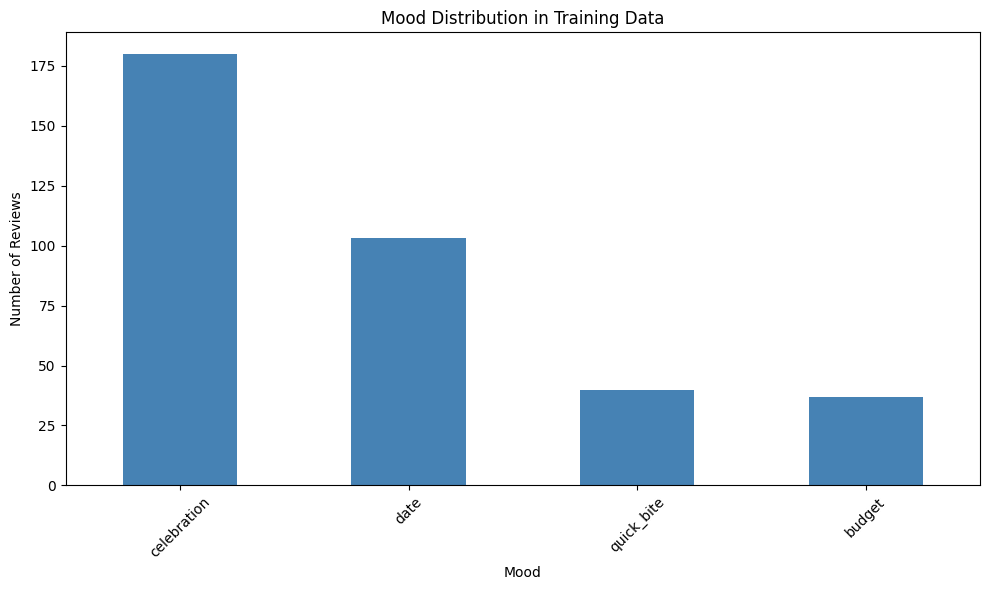


Mood Distribution:
celebration: 180 (79.3%)
date: 103 (45.4%)
quick_bite: 40 (17.6%)
budget: 37 (16.3%)

Average moods per review: 1.83


In [33]:
# Analyze mood distribution
mood_counts = df[MOODS].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
mood_counts.plot(kind='bar', color='steelblue')
plt.title('Mood Distribution in Training Data')
plt.xlabel('Mood')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print('\nMood Distribution:')
for mood, count in mood_counts.items():
    percentage = (count / len(df)) * 100
    print(f'{mood}: {count} ({percentage:.1f}%)')

# Calculate average moods per review
avg_moods = df['moods'].apply(len).mean()
print(f'\nAverage moods per review: {avg_moods:.2f}')

## Data Preparation

In [34]:
# Prepare features and labels
texts = df['review_text'].tolist()
labels = df[MOODS].values.astype(np.float32)

print(f'Number of texts: {len(texts)}')
print(f'Labels shape: {labels.shape}')
print(f'Sample label vector: {labels[0]}')

Number of texts: 227
Labels shape: (227, 4)
Sample label vector: [0. 0. 0. 1.]


In [35]:
# Split data: 70% train, 15% val, 15% test
# First split: 70% train, 30% temp
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.3, random_state=SEED, stratify=None
)

# Second split: 50% val, 50% test from temp (15% each of original)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=SEED, stratify=None
)

print(f'Train set: {len(train_texts)} samples')
print(f'Validation set: {len(val_texts)} samples')
print(f'Test set: {len(test_texts)} samples')

Train set: 158 samples
Validation set: 34 samples
Test set: 35 samples


In [36]:
# Initialize tokenizer
MODEL_NAME = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

# Tokenization parameters
MAX_LENGTH = 128

print(f'Tokenizer loaded: {MODEL_NAME}')
print(f'Max sequence length: {MAX_LENGTH}')

Tokenizer loaded: distilbert-base-uncased
Max sequence length: 128


In [37]:
# Create custom Dataset class
class MoodDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

# Create datasets
train_dataset = MoodDataset(train_texts, train_labels, tokenizer, MAX_LENGTH)
val_dataset = MoodDataset(val_texts, val_labels, tokenizer, MAX_LENGTH)
test_dataset = MoodDataset(test_texts, test_labels, tokenizer, MAX_LENGTH)

print('Datasets created successfully')

Datasets created successfully


In [38]:
# Create DataLoaders
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Batch size: {BATCH_SIZE}')
print(f'Train batches: {len(train_loader)}')
print(f'Val batches: {len(val_loader)}')
print(f'Test batches: {len(test_loader)}')

Batch size: 16
Train batches: 10
Val batches: 3
Test batches: 3


## Model Setup

In [39]:
# Calculate class weights for imbalanced data
pos_counts = train_labels.sum(axis=0)
neg_counts = len(train_labels) - pos_counts

# Weight = num_negative / num_positive for each class
pos_weights = torch.tensor(neg_counts / pos_counts, dtype=torch.float).to(device)

print('Positive class weights (higher = more emphasis on minority class):')
for mood, weight in zip(MOODS, pos_weights):
    print(f'{mood}: {weight:.2f}')

Positive class weights (higher = more emphasis on minority class):
date: 1.19
quick_bite: 4.64
budget: 5.08
celebration: 0.31


In [46]:
# Load pre-trained DistilBERT with custom classification head
from torch import nn

class DistilBertForMultiLabelClassification(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.distilbert = DistilBertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels
        )
        # DistilBERT already has a classifier head, we just need to ensure proper config
        self.distilbert.config.problem_type = "multi_label_classification"

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        return outputs

model = DistilBertForMultiLabelClassification(MODEL_NAME, NUM_LABELS)
model = model.to(device)

print(f'Model loaded and moved to {device}')
print(f'\nModel architecture:\n{model}')

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Model loaded and moved to cuda

Model architecture:
DistilBertForMultiLabelClassification(
  (distilbert): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): DistilBertSelfAttention(
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (sa

In [47]:
# Training hyperparameters
EPOCHS = 100
LEARNING_RATE = 2e-5
WARMUP_STEPS = 100

# Optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

# Loss function with class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

print(f'Epochs: {EPOCHS}')
print(f'Learning rate: {LEARNING_RATE}')
print(f'Total training steps: {total_steps}')
print(f'Warmup steps: {WARMUP_STEPS}')

Epochs: 100
Learning rate: 2e-05
Total training steps: 1000
Warmup steps: 100


## Training Functions

In [50]:
def train_epoch(model, dataloader, optimizer, scheduler, criterion, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0

    progress_bar = tqdm(dataloader, desc='Training')

    for batch in progress_bar:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask)
        logits = outputs.logits

        # Calculate loss
        loss = criterion(logits, labels)

        # Backward pass
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device, threshold=0.5):
    """Evaluate model on validation/test set"""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask)
            logits = outputs.logits

            # Calculate loss
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # Get predictions (apply sigmoid + threshold)
            probs = torch.sigmoid(logits)
            predictions = (probs > threshold).float()

            all_predictions.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Concatenate all batches
    all_predictions = np.vstack(all_predictions)
    all_labels = np.vstack(all_labels)

    # Calculate metrics
    avg_loss = total_loss / len(dataloader)
    f1_micro = f1_score(all_labels, all_predictions, average='micro', zero_division=0)
    f1_macro = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    f1_per_class = f1_score(all_labels, all_predictions, average=None, zero_division=0)

    return avg_loss, f1_micro, f1_macro, f1_per_class, all_predictions, all_labels

## Training Loop

In [51]:
# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_f1_micro': [],
    'val_f1_macro': []
}

best_f1 = 0
patience = 10
patience_counter = 0

print('Starting training...\n')

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 50)

    # Train
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, criterion, device)

    # Evaluate
    val_loss, val_f1_micro, val_f1_macro, val_f1_per_class, _, _ = evaluate(
        model, val_loader, criterion, device
    )

    # Update history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_f1_micro'].append(val_f1_micro)
    history['val_f1_macro'].append(val_f1_macro)

    print(f'\nTrain Loss: {train_loss:.4f}')
    print(f'Val Loss: {val_loss:.4f}')
    print(f'Val F1 (micro): {val_f1_micro:.4f}')
    print(f'Val F1 (macro): {val_f1_macro:.4f}')

    print('\nPer-class F1 scores:')
    for mood, f1 in zip(MOODS, val_f1_per_class):
        print(f'  {mood}: {f1:.4f}')

    # Save best model
    if val_f1_macro > best_f1:
        best_f1 = val_f1_macro
        patience_counter = 0

        # Save model
        os.makedirs('models/distilbert-mood-classifier', exist_ok=True)
        model.distilbert.save_pretrained('models/distilbert-mood-classifier')
        tokenizer.save_pretrained('models/distilbert-mood-classifier')

        print(f'\nNew best model saved! F1: {best_f1:.4f}')
    else:
        patience_counter += 1
        print(f'\nNo improvement. Patience: {patience_counter}/{patience}')

    print('\n')

    # Early stopping
    if patience_counter >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs')
        break

print('Training complete!')

Starting training...

Epoch 1/100
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.8456
Val Loss: 1.0101
Val F1 (micro): 0.1475
Val F1 (macro): 0.1219

Per-class F1 scores:
  date: 0.0000
  quick_bite: 0.2105
  budget: 0.2105
  celebration: 0.0667


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


New best model saved! F1: 0.1219


Epoch 2/100
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.8446
Val Loss: 1.0133
Val F1 (micro): 0.1475
Val F1 (macro): 0.1219

Per-class F1 scores:
  date: 0.0000
  quick_bite: 0.2105
  budget: 0.2105
  celebration: 0.0667

No improvement. Patience: 1/10


Epoch 3/100
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.8430
Val Loss: 1.0158
Val F1 (micro): 0.1488
Val F1 (macro): 0.1234

Per-class F1 scores:
  date: 0.0000
  quick_bite: 0.2162
  budget: 0.2105
  celebration: 0.0667


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


New best model saved! F1: 0.1234


Epoch 4/100
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.8365
Val Loss: 1.0274
Val F1 (micro): 0.1087
Val F1 (macro): 0.1038

Per-class F1 scores:
  date: 0.0000
  quick_bite: 0.1818
  budget: 0.1667
  celebration: 0.0667

No improvement. Patience: 1/10


Epoch 5/100
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.8315
Val Loss: 1.0364
Val F1 (micro): 0.2444
Val F1 (macro): 0.2332

Per-class F1 scores:
  date: 0.4375
  quick_bite: 0.2857
  budget: 0.1429
  celebration: 0.0667


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


New best model saved! F1: 0.2332


Epoch 6/100
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.8224
Val Loss: 1.0520
Val F1 (micro): 0.4270
Val F1 (macro): 0.2477

Per-class F1 scores:
  date: 0.6667
  quick_bite: 0.0000
  budget: 0.0000
  celebration: 0.3243


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


New best model saved! F1: 0.2477


Epoch 7/100
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.7976
Val Loss: 1.0857
Val F1 (micro): 0.6038
Val F1 (macro): 0.3391

Per-class F1 scores:
  date: 0.6364
  quick_bite: 0.0000
  budget: 0.0000
  celebration: 0.7200


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


New best model saved! F1: 0.3391


Epoch 8/100
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.7477
Val Loss: 1.2183
Val F1 (micro): 0.7350
Val F1 (macro): 0.3858

Per-class F1 scores:
  date: 0.6250
  quick_bite: 0.0000
  budget: 0.0000
  celebration: 0.9180


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


New best model saved! F1: 0.3858


Epoch 9/100
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.6821
Val Loss: 1.1302
Val F1 (micro): 0.7544
Val F1 (macro): 0.4052

Per-class F1 scores:
  date: 0.7000
  quick_bite: 0.0000
  budget: 0.0000
  celebration: 0.9206


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


New best model saved! F1: 0.4052


Epoch 10/100
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.6054
Val Loss: 0.9492
Val F1 (micro): 0.6842
Val F1 (macro): 0.5257

Per-class F1 scores:
  date: 0.5161
  quick_bite: 0.3636
  budget: 0.3077
  celebration: 0.9153


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


New best model saved! F1: 0.5257


Epoch 11/100
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.5414
Val Loss: 1.6030
Val F1 (micro): 0.7458
Val F1 (macro): 0.3897

Per-class F1 scores:
  date: 0.6383
  quick_bite: 0.0000
  budget: 0.0000
  celebration: 0.9206

No improvement. Patience: 1/10


Epoch 12/100
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.4637
Val Loss: 1.6771
Val F1 (micro): 0.7521
Val F1 (macro): 0.3932

Per-class F1 scores:
  date: 0.6522
  quick_bite: 0.0000
  budget: 0.0000
  celebration: 0.9206

No improvement. Patience: 2/10


Epoch 13/100
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.3867
Val Loss: 0.8181
Val F1 (micro): 0.6239
Val F1 (macro): 0.5085

Per-class F1 scores:
  date: 0.4286
  quick_bite: 0.3077
  budget: 0.4615
  celebration: 0.8364

No improvement. Patience: 3/10


Epoch 14/100
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.3424
Val Loss: 1.9555
Val F1 (micro): 0.7103
Val F1 (macro): 0.3687

Per-class F1 scores:
  date: 0.5714
  quick_bite: 0.0000
  budget: 0.0000
  celebration: 0.9032

No improvement. Patience: 4/10


Epoch 15/100
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.2973
Val Loss: 1.1856
Val F1 (micro): 0.7115
Val F1 (macro): 0.5908

Per-class F1 scores:
  date: 0.4667
  quick_bite: 0.5000
  budget: 0.5000
  celebration: 0.8966


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


New best model saved! F1: 0.5908


Epoch 16/100
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.2604
Val Loss: 1.7988
Val F1 (micro): 0.7170
Val F1 (macro): 0.5174

Per-class F1 scores:
  date: 0.4848
  quick_bite: 0.3333
  budget: 0.3333
  celebration: 0.9180

No improvement. Patience: 1/10


Epoch 17/100
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.2269
Val Loss: 2.3410
Val F1 (micro): 0.7222
Val F1 (macro): 0.3782

Per-class F1 scores:
  date: 0.5946
  quick_bite: 0.0000
  budget: 0.0000
  celebration: 0.9180

No improvement. Patience: 2/10


Epoch 18/100
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.2030
Val Loss: 2.7123
Val F1 (micro): 0.7257
Val F1 (macro): 0.3730

Per-class F1 scores:
  date: 0.5714
  quick_bite: 0.0000
  budget: 0.0000
  celebration: 0.9206

No improvement. Patience: 3/10


Epoch 19/100
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1674
Val Loss: 2.5553
Val F1 (micro): 0.7103
Val F1 (macro): 0.3611

Per-class F1 scores:
  date: 0.5263
  quick_bite: 0.0000
  budget: 0.0000
  celebration: 0.9180

No improvement. Patience: 4/10


Epoch 20/100
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1461
Val Loss: 1.9457
Val F1 (micro): 0.7184
Val F1 (macro): 0.5207

Per-class F1 scores:
  date: 0.5161
  quick_bite: 0.3333
  budget: 0.3333
  celebration: 0.9000

No improvement. Patience: 5/10


Epoch 21/100
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1268
Val Loss: 1.9996
Val F1 (micro): 0.7200
Val F1 (macro): 0.4924

Per-class F1 scores:
  date: 0.4828
  quick_bite: 0.5714
  budget: 0.0000
  celebration: 0.9153

No improvement. Patience: 6/10


Epoch 22/100
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.1125
Val Loss: 2.2170
Val F1 (micro): 0.7255
Val F1 (macro): 0.4462

Per-class F1 scores:
  date: 0.5333
  quick_bite: 0.0000
  budget: 0.3333
  celebration: 0.9180

No improvement. Patience: 7/10


Epoch 23/100
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.0971
Val Loss: 2.5698
Val F1 (micro): 0.6931
Val F1 (macro): 0.3462

Per-class F1 scores:
  date: 0.4667
  quick_bite: 0.0000
  budget: 0.0000
  celebration: 0.9180

No improvement. Patience: 8/10


Epoch 24/100
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.0873
Val Loss: 2.7865
Val F1 (micro): 0.6916
Val F1 (macro): 0.3545

Per-class F1 scores:
  date: 0.5000
  quick_bite: 0.0000
  budget: 0.0000
  celebration: 0.9180

No improvement. Patience: 9/10


Epoch 25/100
--------------------------------------------------


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Train Loss: 0.0780
Val Loss: 2.6892
Val F1 (micro): 0.7059
Val F1 (macro): 0.3585

Per-class F1 scores:
  date: 0.5161
  quick_bite: 0.0000
  budget: 0.0000
  celebration: 0.9180

No improvement. Patience: 10/10


Early stopping triggered after 25 epochs
Training complete!


## Plot Training History

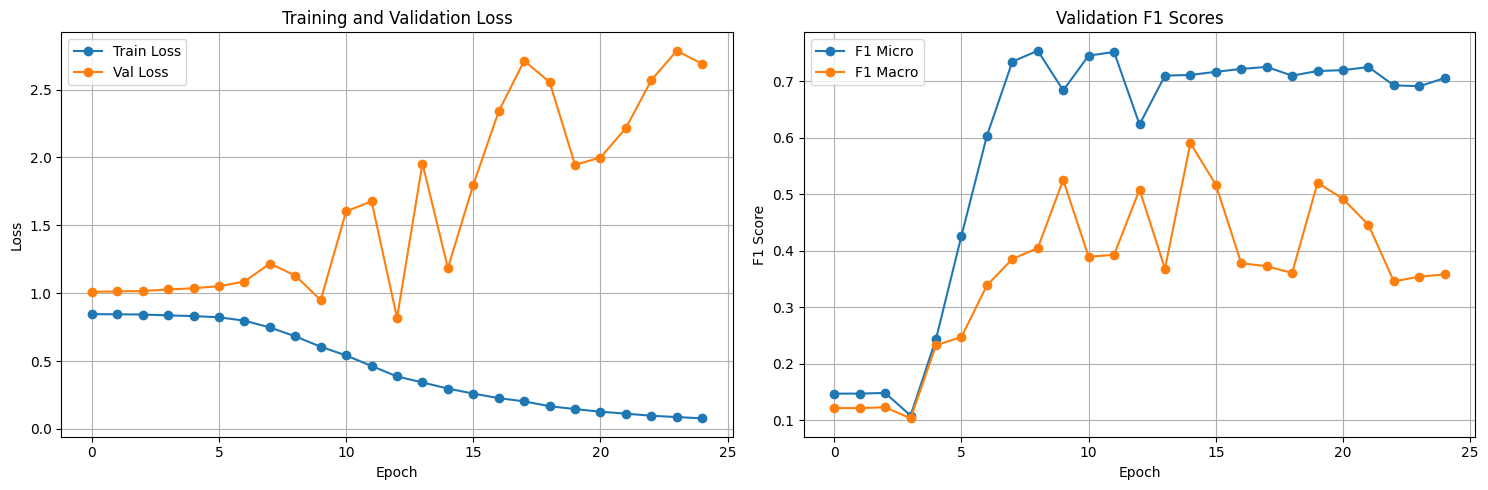

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# F1 plot
axes[1].plot(history['val_f1_micro'], label='F1 Micro', marker='o')
axes[1].plot(history['val_f1_macro'], label='F1 Macro', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('Validation F1 Scores')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('models/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

## Final Evaluation on Test Set

In [53]:
# Load best model
best_model = DistilBertForMultiLabelClassification('models/distilbert-mood-classifier', NUM_LABELS)
best_model = best_model.to(device)

print('Best model loaded for final evaluation')

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

Best model loaded for final evaluation


In [54]:
# Evaluate on test set
test_loss, test_f1_micro, test_f1_macro, test_f1_per_class, test_preds, test_labels_actual = evaluate(
    best_model, test_loader, criterion, device
)

print('Test Set Results:')
print('=' * 50)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test F1 (micro): {test_f1_micro:.4f}')
print(f'Test F1 (macro): {test_f1_macro:.4f}')
print('\nPer-mood Performance:')
print('-' * 50)

for mood, f1 in zip(MOODS, test_f1_per_class):
    precision = precision_score(test_labels_actual[:, MOODS.index(mood)],
                                test_preds[:, MOODS.index(mood)], zero_division=0)
    recall = recall_score(test_labels_actual[:, MOODS.index(mood)],
                         test_preds[:, MOODS.index(mood)], zero_division=0)

    print(f'{mood}:')
    print(f'  Precision: {precision:.4f}')
    print(f'  Recall: {recall:.4f}')
    print(f'  F1: {f1:.4f}')

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Test Set Results:
Test Loss: 0.8308
Test F1 (micro): 0.7544
Test F1 (macro): 0.6852

Per-mood Performance:
--------------------------------------------------
date:
  Precision: 0.7778
  Recall: 0.4667
  F1: 0.5833
quick_bite:
  Precision: 0.7000
  Recall: 0.8750
  F1: 0.7778
budget:
  Precision: 0.4000
  Recall: 0.5714
  F1: 0.4706
celebration:
  Precision: 1.0000
  Recall: 0.8333
  F1: 0.9091


In [55]:
# Save test metrics
test_metrics = {
    'test_loss': float(test_loss),
    'test_f1_micro': float(test_f1_micro),
    'test_f1_macro': float(test_f1_macro),
    'per_mood_metrics': {}
}

for i, mood in enumerate(MOODS):
    test_metrics['per_mood_metrics'][mood] = {
        'f1': float(test_f1_per_class[i]),
        'precision': float(precision_score(test_labels_actual[:, i], test_preds[:, i], zero_division=0)),
        'recall': float(recall_score(test_labels_actual[:, i], test_preds[:, i], zero_division=0))
    }

with open('models/test_metrics.json', 'w') as f:
    json.dump(test_metrics, f, indent=2)

print('\nTest metrics saved to models/test_metrics.json')


Test metrics saved to models/test_metrics.json


## Save Model to Google Drive (Colab)

In [56]:
# Mount Google Drive (Colab only)
if 'COLAB_GPU' in os.environ:
    from google.colab import drive
    drive.mount('/content/drive')

    # Copy model to Drive
    !cp -r models/distilbert-mood-classifier /content/drive/MyDrive/
    !cp models/test_metrics.json /content/drive/MyDrive/distilbert-mood-classifier/
    !cp models/training_history.png /content/drive/MyDrive/distilbert-mood-classifier/

    print('Model saved to Google Drive!')

Mounted at /content/drive
Model saved to Google Drive!


## Next Steps
1. Download model from Google Drive
2. Push to GitHub (if < 100MB) or use Git LFS
3. Upload to HuggingFace Hub
4. Integrate into backend API